In [4]:
import hazelbean as hb
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt

import os

In [77]:
ssp_list = ['ssp1','ssp2','ssp3','ssp4','ssp5']
rcp_list = ['26','45','60','60','85']
gcm_list = ['cc','gs','he','mr']

## Theory

/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


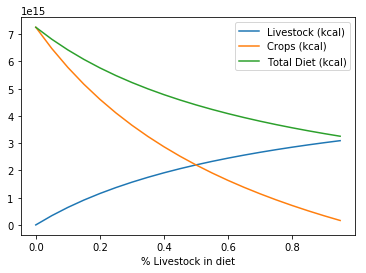

In [2]:
#pct_DietLS2050 = 0.15
df = pd.DataFrame(columns=['% Livestock in diet','Livestock (kcal)','Crops (kcal)','Total Diet 2050 (kcal)'])

Production = 9.1e15
pct_Prodfood = 0.52
feed_conversion_factor = 2.293651
LS2000 = 1.1e15

FoodCropsKcal2000 = 4.7684e+15


for pct_DietLS2050 in np.arange(0,1,0.05,dtype=float):
    LS_2050 = pct_DietLS2050 * (Production*pct_Prodfood + feed_conversion_factor*LS2000) / (1 + pct_DietLS2050*(feed_conversion_factor-1)) 
    
    
    FoodCrops_2050 = Production * pct_Prodfood + feed_conversion_factor * (LS2000-LS_2050) 

    TotDiet_2050 = FoodCrops_2050 + LS_2050
    
    df = df.append({'% Livestock in diet':pct_DietLS2050,
                   'Livestock (kcal)':LS_2050,
                   'Crops (kcal)':FoodCrops_2050,
                   'Total Diet (kcal)':TotDiet_2050},ignore_index=True)

df.plot(x='% Livestock in diet',y=['Livestock (kcal)','Crops (kcal)','Total Diet (kcal)']);#,figsize(10,20))
    

## FAO/Earthstat different total productions :/

In [ ]:
# FAO total prod:       9.1 e18 cal --> after agricultural losses (maybe 15%?)
# Earthstat total prod: 16.8 e18 cal 

In [ ]:
# "nutritonally relevant" Crops included

In [173]:
crop_list_ea = pd.read_csv('../Data/inputs/Crop/crop_table.csv')

crop_list_FAO = pd.read_csv('../Data/inputs/Crop/crop_table_FAO_Mika.csv')

crop_list_FAO.head()

crop_list_merged = crop_list_FAO.merge(crop_list_ea,right_on='file_name',left_on='ItemName_1',how='outer')

In [174]:
len(crop_list_ea)

175

In [177]:
crop_list_ea

,file_name,nutritional_relevance
0,aniseetc,0
1,cinnamon,0
2,clove,0
3,coffee,0
4,karite,0
5,melonseed,0
6,mustard,0
7,nutmeg,0
8,oilpalm,0
9,pepper,0


In [175]:
len(crop_list_FAO)

123

In [176]:
crop_list_FAO

,ItemName_1,ItemName_2
0,NaN,0.0
1,Wheat,1.0
2,Barley,1.0
3,Maize,1.0
4,Rye,1.0
5,Oats,1.0
6,Millet,1.0
7,Sorghum,1.0
8,"Cereals, Other",1.0
9,Potatoes,1.0


# Utils

In [213]:
# Global 
pctLS_2000 = .19
LS_2000 = 1.1483e15*1e3 #calories

pct_Prod_Food_2000 = .52
feed_conversion_factor = 2.3

In [ ]:
LS_2000 per country
pctLS_2000 # from Bodirsky!
Consumption data per country 2000 ?!!




In [214]:
def calc_CalSuff(prod_available, LS, pop,
            caloric_req = (2320*1e3*365.25) #in cal/capita/yr
           ):
    ''' prod_available (for Food not Feed + accounting for losses) - in Calories
        LS : animal calories availables
        pop : in capita
        caloric_req : default values is ADER=2320 kcal/cap/d (without fish)
        
        This is all per year
    '''
    return (prod_available + LS) / (caloric_req * pop)
    

In [215]:
def calc_CalSuff_2050(pct_LS_2050,
                      prod_2050,
                      pop_2050):
    
    LS_2050 = pctLS_2050 * (prod_2050*pct_Prod_Food_2000 + feed_conversion_factor*LS_2000) / (1 + pctLS_2050*(feed_conversion_factor-1)) 

    feed_now_food = feed_conversion_factor * (LS_2000-LS_2050)
    
    prod_available = prod_2050*pct_Prod_Food_2000 + feed_now_food

    calsuff_2050 = calc_CalSuff(prod_available,
                           LS_2050,
                           pop_2050)
    
    return calsuff_2050

# Global

## Data

See Method - Caloric Sufficiency Calc

In [ ]:
#Caloric requirement
#ADER = 2355 (w.o fish 2320)

caloric_req = 2320 * 1e3 * 365.25 #in cal/capita/yr

In [125]:
# Population 

def get_total_pop(ssp):
    '''ssp: 2000 or ssp'''
    
    pop_dir = '../Data/intermediate/Population_csvs'
    if ssp.startswith('ssp'):
        pop = pd.read_csv(os.path.join(pop_dir,'adjusted_'+ssp+'.csv'))
    else:
        pop = pd.read_csv(os.path.join(pop_dir,ssp+'.csv'))
    pop = pop.set_index('pixel_id')
    pop_tot = pop['gpw_population'].sum()
    return pop_tot

In [16]:
def get_total_prod(ssp):
    '''ssp: 2000 or ssp'''
    
    results_dir = '../Data/outputs/Model_results/All_Change/xgb3_Allinputs'
    if ssp == '2000':
        rez = pd.read_csv(os.path.join(results_dir,'ssp1_composite.csv'))
        return rez['Calories 2000'].sum()
    
    else:
        rez = pd.read_csv(os.path.join(results_dir,ssp+'_composite.csv'))
        #rez = rez.set_index('pixel_id')
        return rez['Calories 2050'].sum()

## Caloric Sufficiency equations

## Global caloric sufficiency 

### 2000

In [100]:
pctLS_2000 = .19
LS_2000 = 1.1483e15*1e3 #calories

pct_Prod_Food = .52


pop_2000 = get_total_pop('2000')
prod_2000 = get_total_prod('2000') # calories

In [103]:
prod_available = prod_2000*pct_Prod_Food

global_CalSuff_2000 = calc_CalSuff(prod_available,
                       LS_2000,
                       pop_2000)

global_CalSuff_2000

1.9568988513886614

### SSPs

In [51]:
feed_conversion_factor = 2.3

# Data source: Bodirsky : share of calories in diet from animal products
pctLS_2050 = .19 #Assuming cst

In [81]:
def global_CalSuff_2050(ssp,
                        pctLS_2050 = .19):
    
    prod_2050 = get_total_prod(ssp)
    
    LS_2050 = pctLS_2050 * (prod_2050*pct_Prod_Food + feed_conversion_factor*LS_2000) / (1 + pctLS_2050*(feed_conversion_factor-1)) 

    feed_now_food = feed_conversion_factor * (LS_2000-LS_2050)
    
    prod_available = prod_2050*pct_Prod_Food + feed_now_food
    
    pop = get_total_pop(ssp)

    calsuff = calc_CalSuff(prod_available,
                           LS_2050,
                           pop)
    
    return calsuff


In [121]:
CalSuff_df = pd.DataFrame(columns=['ssp','global_CalSuff','pctLS'])

In [122]:
for ssp in ssp_list:
    for pctLS_2050 in [0,.05,.1,.11,.12,.13,.14,.15,.16,.17,.18,.19,.20,.21,.22,.23,.25,.30]:
        
        CalSuff = global_CalSuff_2050(ssp,
                                     pctLS_2050)

        CalSuff_df = CalSuff_df.append({'ssp':ssp,'global_CalSuff':CalSuff,'pctLS':pctLS_2050},ignore_index=True)

### Plot

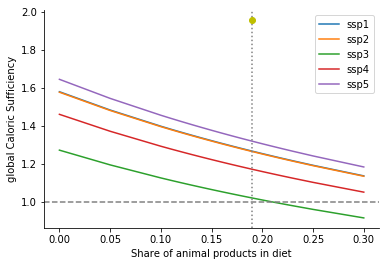

In [123]:
fig, ax = plt.subplots()

for ssp, grp in CalSuff_df.groupby(['ssp']):
    ax = grp.plot(ax=ax, kind='line', x='pctLS', y='global_CalSuff', label=ssp)

plt.axvline(x=.19,linestyle=':',color='grey')
plt.axhline(y=1,linestyle='--',color='grey')

# Baseline
plt.plot(.19, global_CalSuff_2000, 'yo') 

#Prettify
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylabel('global Caloric Sufficiency');
plt.xlabel('Share of animal products in diet');
plt.legend(loc='best');


# By country

In [293]:
countries_ids = countries['country_id'].unique()
len(countries_ids)

235

In [182]:
#countries_list = countries['ISO3'].unique() #254
countries_list = pop_bycountry[pop_bycountry>0].index #229

254

In [300]:
CalSuffs = pd.DataFrame()
CalSuffs['country'] = countries_list
CalSuffs = CalSuffs.set_index('country')

## CalSuff 2000 (country-level)
(based on Modeled data -> think about that)

Big assumption for preliminary estimations: pct_Prod_Food_2000 (Losses) constant across countries (but anyway I'm saying it'll be constant in 2050 too...)
These pct_Prod_Food_2000 should likely be at country-level 

 If you want to change the pct_Prod_Food_2000 to do it by country...
 
 pct_Prod_Food_2000 = Consumption_Food_2000 / Production_Crops_2000 
 
 
        #Consumption_Food_2000 = Grand total from Diets
        Conso_2000_df = diet_2000[diet_2000['Item']=='Grand Total'][['Country','Value']].merge(countries[['name','ISO3']].drop_duplicates(),
                                                                                                right_on='name',left_on='Country',how='left')
        # kcal/capita/day to cal/capita
        Conso_2000_df['Conso2000_percapita'] = Conso_2000_df['Value'].apply(lambda x:x*1e3*365.25)

        --> must do Conso_2000 * pop

In [352]:
# LS 2000 Data
diet_2000 = pd.read_csv('../Data/inputs/Diet/Consumption_2000_FAOSTAT.csv')

LS_2000_df = diet_2000[diet_2000['Item']=='Animal Products'][['Country','Value']].merge(countries[['name','ISO3']].drop_duplicates(),
                                                                                        right_on='name',left_on='Country',how='left')
# kcal/capita/day to cal/capita
LS_2000_df['LS2000_percapita']=LS_2000_df['Value'].apply(lambda x:x*1e3*365.25)



LS_2000_df = LS_2000_df[['name','ISO3','LS2000_percapita']].set_index('ISO3')

In [353]:
# Population by country
pop_dir = '../Data/intermediate/Population_csvs'
pop = pd.read_csv(os.path.join(pop_dir,'2000.csv'))
pop = pop.merge(countries,right_on='pixel_id',left_on='pixel_id')
pop_bycountry = pop.groupby('ISO3')['gpw_population'].sum()

# Production by country
prod = pd.read_csv(os.path.join(results_dir,ssp+'_composite.csv'))
prod = prod.merge(countries,right_on='pixel_id',left_on='pixel_id')
prod_bycountry = prod.groupby('ISO3')['Calories 2000'].sum()

for country in countries_list:
    # Diet 
    pct_LS_2050 = diets[(diets['Scenario'] == ssp) & (diets['Region'] == country)]['2000']

    # Production
    try:
        prod_bycountry[country]
    except KeyError:
        prod_country = 0
    else:
         prod_country =  prod_bycountry[country]
            
    # LS 2000
    try:
        LS2000 = LS_2000_df.at[country,'LS2000_percapita'] * pop_bycountry[country]
    except KeyError:
        LS2000 = 0
    
    # Caloric sufficiency
    calsuff = calc_CalSuff(prod_available=(prod_country * pct_Prod_Food_2000),
                             LS=LS2000,
                             pop=pop_bycountry[country])

    CalSuffs.at[country,'CalSuff_2000'] = calsuff

In [351]:
LS_2000_df['LS2000'].sum()

89549000.0

## 2050

In [313]:
# Load countries data if it hasn't been done before
try:
    countries
except NameError:
    countries = pd.read_csv('../Data/intermediate/Crop_csvs/country_ids.csv')
    countries_names = pd.read_csv('../Data/inputs/Base/country_names.csv',encoding='latin-1')
    countries = countries[['country_id','pixel_id']].merge(countries_names[['base_id','ISO3','name']],right_on='base_id',left_on='country_id',how='right')
    
# Load diets data
diets = pd.read_csv('../Data/inputs/Diet/pctLS_SSPs_Bodirsky.csv',sep=';')

for ssp in ssp_list:

    # Population by country
    pop_dir = '../Data/intermediate/Population_csvs'
    pop = pd.read_csv(os.path.join(pop_dir,'adjusted_'+ssp+'.csv'))
    pop = pop.merge(countries,right_on='pixel_id',left_on='pixel_id')
    pop_bycountry = pop.groupby('ISO3')['gpw_population'].sum()

    # Production by country
    prod = pd.read_csv(os.path.join(results_dir,ssp+'_composite.csv'))
    prod = prod.merge(countries,right_on='pixel_id',left_on='pixel_id')
    prod_bycountry = prod.groupby('ISO3')['Calories 2050'].sum()

    for country in countries_list:
        # Diet 
        pct_LS_2050 = diets[(diets['Scenario'] == ssp) & (diets['Region'] == country)]['2050']

        # Production
        try:
            prod_bycountry[country]
        except KeyError:
            prod_country = 0
        else:
             prod_country =  prod_bycountry[country]

        # Caloric sufficiency
        calsuff = calc_CalSuff_2050(pct_LS_2050,
                              prod_country,
                              pop_bycountry[country])

        CalSuffs.at[country,'CalSuff_'+ssp] = calsuff

CalSuffs

,CalSuff,CalSuff_ssp1,CalSuff_ssp2,CalSuff_ssp3,CalSuff_ssp4,CalSuff_ssp5
country,,,,,,
AFG,3.357803e+01,4.276513e+01,3.357803e+01,2.976616e+01,2.947020e+01,4.339231e+01
AGO,5.331064e+01,5.341645e+01,5.331064e+01,3.747308e+01,3.636031e+01,5.389399e+01
ALB,8.027463e+02,8.036493e+02,8.027463e+02,8.026684e+02,8.035498e+02,8.036757e+02
ALD,1.442910e+05,1.442910e+05,1.442910e+05,1.442910e+05,1.442910e+05,1.442910e+05
AND,3.328507e+04,3.328507e+04,3.328507e+04,3.328507e+04,3.328507e+04,3.328507e+04
ARE,1.461367e+02,1.462225e+02,1.461367e+02,1.467323e+02,1.462200e+02,1.174945e+02
ARG,6.033860e+01,5.989025e+01,6.033860e+01,5.966827e+01,5.982557e+01,6.017842e+01
ARM,7.519953e+02,7.651017e+02,7.519953e+02,7.511025e+02,7.692682e+02,8.591823e+02
ASM,1.036654e+05,1.036654e+05,1.036654e+05,1.036654e+05,1.036654e+05,1.036654e+05


###### Fix the CalSuff 2050 (they look too big..)

###### Export and map

LS_2000 is for the World ! Not per country !

# Work in progress zone

In [357]:
CalSuffs[['CalSuff_2000']].to_csv('../Data/outputs/Caloric_sufficiency/country_CalSuffs.csv')

In [360]:
type(CalSuffs['CalSuff_2000']['ALD'])

numpy.float64

In [332]:
len(diets_2000.Country.unique())

175

In [345]:
diet_2000 = pd.read_csv('../Data/inputs/Diet/Consumption_2000_FAOSTAT.csv')

LS_2000_df = diet_2000[diet_2000['Item']=='Animal Products'][['Country','Value']].merge(countries[['name','ISO3']].drop_duplicates(),
                                                                                        right_on='name',left_on='Country',how='left')
# kcal to cal
LS_2000_df['LS2000']=LS_2000_df['Value'].apply(lambda x:x*1e3)
LS_2000_df = LS_2000_df[['name','ISO3','LS2000']].set_index('ISO3')
LS_2000_df

,name,LS2000
ISO3,,
AFG,Afghanistan,275000.0
ALB,Albania,674000.0
DZA,Algeria,277000.0
AGO,Angola,153000.0
ATG,Antigua and Barbuda,701000.0
ARG,Argentina,1014000.0
ARM,Armenia,347000.0
AUS,Australia,987000.0
AUT,Austria,1174000.0


In [334]:
diet_2000 = pd.read_csv('../Data/inputs/Diet/Consumption_2000_FAOSTAT.csv')
diet_2000.head(12)

,Domain,Country,Element,Item,Year,Unit,Value
0,Food Balance Sheets,Afghanistan,Food supply (kcal/capita/day),Grand Total,2000,kcal/capita/day,1790
1,Food Balance Sheets,Afghanistan,Food supply (kcal/capita/day),Animal Products,2000,kcal/capita/day,275
2,Food Balance Sheets,Afghanistan,Food supply (kcal/capita/day),Meat,2000,kcal/capita/day,93
3,Food Balance Sheets,Afghanistan,Food supply (kcal/capita/day),Offals,2000,kcal/capita/day,7
4,Food Balance Sheets,Afghanistan,Food supply (kcal/capita/day),Animal fats,2000,kcal/capita/day,50
5,Food Balance Sheets,Afghanistan,Food supply (kcal/capita/day),Eggs,2000,kcal/capita/day,2
6,Food Balance Sheets,Afghanistan,Food supply (kcal/capita/day),Milk - Excluding Butter,2000,kcal/capita/day,123
7,Food Balance Sheets,Albania,Food supply (kcal/capita/day),Grand Total,2000,kcal/capita/day,2734
8,Food Balance Sheets,Albania,Food supply (kcal/capita/day),Animal Products,2000,kcal/capita/day,674
9,Food Balance Sheets,Albania,Food supply (kcal/capita/day),Meat,2000,kcal/capita/day,149


In [328]:
123+2+50+7+93

275

In [ ]:
%LS : Animal Products / Grand Total
    LS_2000 = Animal Products

In [222]:
from viz_utils import *

In [255]:
#pop = pd.read_csv(os.path.join(pop_dir,'adjusted_'+ssp+'.csv'))
pop = pop.set_index("pixel_id")

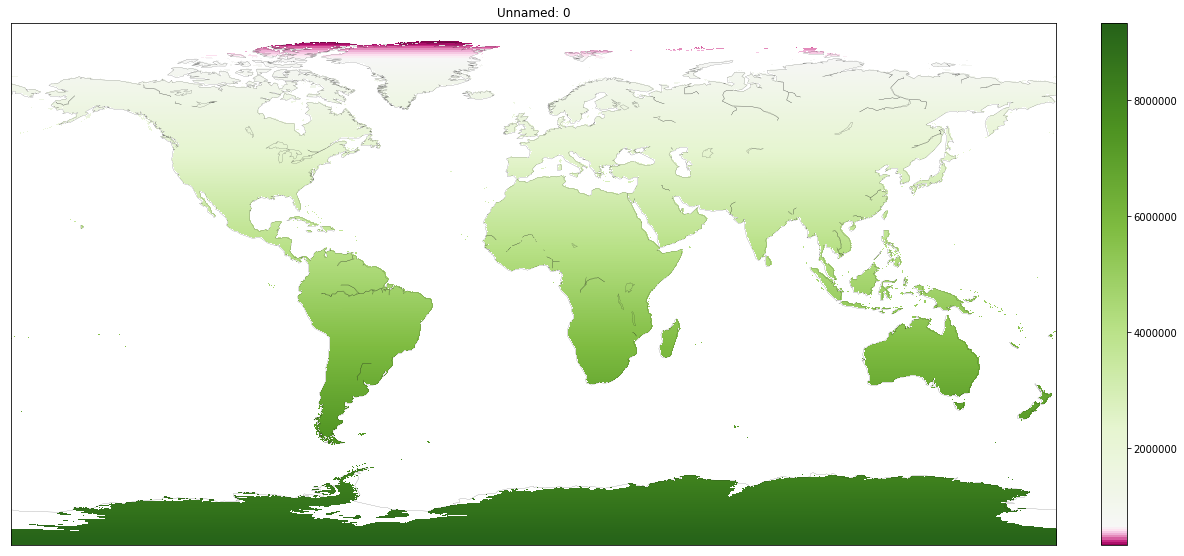

In [256]:
visualize_data(pop,'Unnamed: 0')

In [257]:
export_raster(pop,'Unnamed: 0',
              savefig='../Data/inputs/Base/pixel_ids.tif')

Exported raster at ../Data/inputs/Base/pixel_ids.tif


In [ ]:
pixel_id_Paris = 2131952